In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pytensor as pt
import statistics as stats
from pymc.ode import DifferentialEquation
from scipy.integrate import odeint

In [2]:
DT = 0.25

my_num = 0

eta_cortex = 10**-12 
gamma = eta_cortex/14**2 

L = .5 
gammam = 1 #.35*gamma
gammax = 1 # .8*gamma
shape1 = np.array([1,  .9, 1, 1.1, 1.05, 1, 0.95, 0.9, 0.8, 0.75])
V_p = 0.15*60
V_p = V_p
R = 0.013 

A = (5*L**2)/(108*(R**2/5 + L**2/54)) *gammax*gammam*V_p 

In [3]:
import scipy.io as io

data_gsc = io.loadmat("data/GSC_timealigned_data.mat")
ani_gsc = np.flip(data_gsc["ani_gsc_mean"].flatten())
ani_gsc_SE = np.flip(data_gsc["ani_gsc_SE"].flatten() )
nmy_gsc = np.flip(data_gsc["nmy_gsc_mean"].flatten())
nmy_gsc_SE = np.flip(data_gsc["nmy_gsc_SE"].flatten() )
circumference_gsc = np.flip(data_gsc["c_mean"].flatten() ) 
circumference_gsc_SE = np.flip(data_gsc["c_SE"].flatten() ) 
# Density 
#ani_gsc = np.divide(ani_gsc,circumference_gsc)
#nmy_gsc = np.divide(nmy_gsc,circumference_gsc)

In [4]:
trace_apop_ani = list
trace_apop_nmy = list 
trace_gsc_ani = list 
trace_gsc_nmy = list 
trace_cell_ani = list 
trace_cell_nmy = list 

omega = (gammax*ani_gsc + gammam*nmy_gsc)**2  
ani_nmy = ani_gsc*nmy_gsc

In [5]:
def ringclose(r, t, p): 
    W = p[0]*ani_nmy[0]
    W2 = -r[0]*p[1]*(W/omega[0])
    return W2



times = DT*np.arange(0, 32,1)
#A1, alpha = A , .5

#r = odeint(ringclose, t= times, y0=circumference_gsc[0], args = tuple([[alpha, A1]]))
#plt.plot(r)
#plt.errorbar(np.arange(0,32,1),circumference_gsc, circumference_gsc_SE)
x = np.matrix(circumference_gsc)
circumference_gsc1 = np.array(x.T)

x = np.matrix(circumference_gsc_SE) 
circumference_gsc_SE1 = np.array(x.T)

In [6]:
ode_model = DifferentialEquation(func = ringclose, times = times, n_states = 1, n_theta = 2, t0=0)


with pm.Model() as model:
    
    alpha = pm.Normal('alpha',mu = -.4, sigma = 1)
    #sigma = pm.HalfCauchy("sigma", 1)
    sigma = circumference_gsc_SE1
    ode_solution = ode_model(y0 =circumference_gsc1[0], theta=[alpha, A])
    
    Y = pm.Normal("Y", mu= ode_solution, sigma = sigma, observed = circumference_gsc1)
    
    prior = pm.sample_prior_predictive(10) 
    trace = pm.sample(2000, tune = 1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace) 
    

Sampling: [Y, alpha]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Output()

/home/jlinehan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/ode/ode.py:130: ODEintWarning: Excess 
accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(

/home/jlinehan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/ode/ode.py:130: ODEintWarning: Excess work
done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6335235184195D+01   r2 =                  NaN


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 135 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [Y]


Output()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

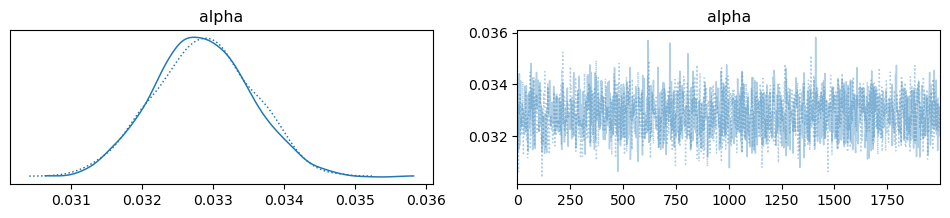

In [7]:
az.plot_trace(trace)

In [22]:
trace.unstack(inplace = "True")
a= az.extract(trace, group = 'posterior', var_names = ['alpha'], keep_dataset = 'true')
alpha = a.alpha.values


active_stress = -((4*np.pi*R**3)/27)*(L**2)/12 * gammam*V_p*nmy_gsc**2 * (-alpha.mean()*ani_gsc*gammam*nmy_gsc)/(gammax*ani_gsc + gammam*nmy_gsc)

viscosity = ((4*np.pi*R**3)/(15))*nmy_gsc**2 * (gammax*ani_gsc + gammam*nmy_gsc)*((R**2)/5 + L**2/54) 
active_stress_approx = -nmy_gsc**2 *(-alpha.mean()*ani_gsc*gammam*nmy_gsc)/(gammax*ani_gsc + gammam*nmy_gsc)
active_stress_noalpha = -nmy_gsc**2 *(-ani_gsc*gammam*nmy_gsc)/(gammax*ani_gsc + gammam*nmy_gsc)
viscosity_approx = nmy_gsc**2 * (gammax*ani_gsc + gammam*nmy_gsc)
alpha.mean()

0.0328509916324707

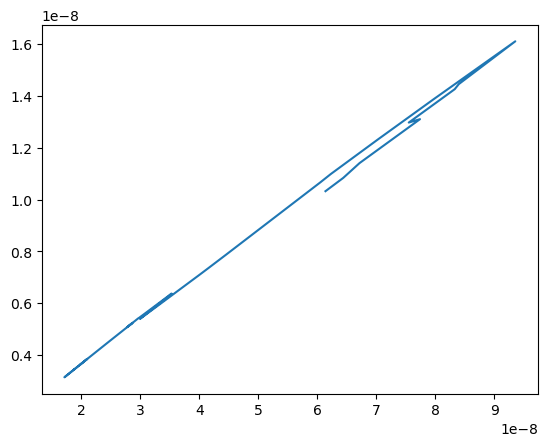

In [23]:
ani_rho = ani_gsc
nmy_rho = nmy_gsc
plt.plot(viscosity, active_stress) 

In [24]:
mcmc_prediction = odeint(ringclose, t=times, y0 = circumference_gsc1[0], args = tuple([[alpha.mean(), A]]))

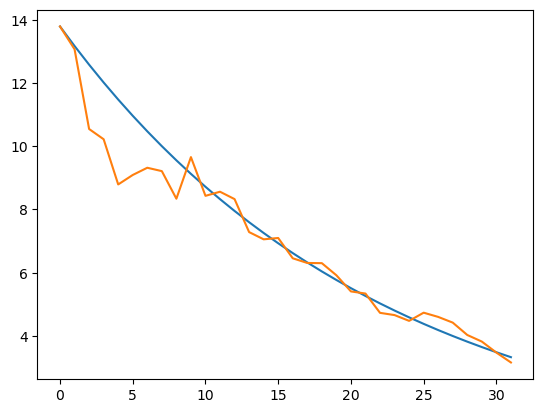

In [25]:
plt.plot(mcmc_prediction)
plt.plot(circumference_gsc)

In [26]:
io.savemat('alpha_x_gsc.mat', dict(alpha = alpha))
io.savemat('active_stress_gsc.mat',dict(active_stress = active_stress))
io.savemat('viscosity_gsc.mat', dict(viscosity = viscosity))
io.savemat('mcmc_c_pred_gsc.mat',dict(mcmc_circumference = mcmc_prediction))
io.savemat('active_stress_gsc_approx.mat',dict(active_stress = active_stress_approx))
io.savemat('active_stress_gsc_noalpha.mat',dict(active_stress = active_stress_noalpha))
io.savemat('viscosity_gsc_approx.mat', dict(viscosity = viscosity_approx))